In [243]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
%matplotlib inline

In [139]:
def get_borders(series):
    '''Определение границ выбросов с учетом межквартильного расстояния'''
    result = []
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)
    IQR = perc75 - perc25
    result.append(perc25 - 1.5*IQR)
    result.append(perc75 + 1.5*IQR)
    return result

Количество наблюдений: 395
Отсутствуют баллы по экзамену - наблюдения исключаются из анализа: 6
Нулевые баллы по экзамену: 37
Положительные баллы по экзамену: 352

Выбросы среди положительных баллов отсутствуют: 352 наблюдения лежат в диапазоне [7.5, 107.5]


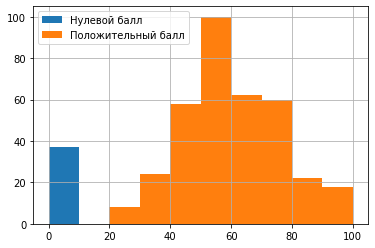

In [179]:
stud_math = pd.read_csv('stud_math.csv')
print('Количество наблюдений:',stud_math.shape[0])
print('Отсутствуют баллы по экзамену - наблюдения исключаются из анализа:',stud_math[stud_math['score'].isnull()].shape[0])
print('Нулевые баллы по экзамену:',stud_math[stud_math['score'] == 0].shape[0])
print('Положительные баллы по экзамену:',stud_math[stud_math['score'] > 0].shape[0])

stud_math[stud_math['score'] == 0].score.hist(range = (0, 100), label = 'Нулевой балл')
stud_math[stud_math['score'] > 0].score.hist(range = (0, 100), label = 'Положительный балл')
plt.legend();

borders = get_borders(stud_math[stud_math['score'] > 0].score)
print('\nВыбросы среди положительных баллов отсутствуют:',
      len(stud_math[(stud_math['score'] > borders[0]) & (stud_math['score'] < borders[1])]),
     'наблюдения лежат в диапазоне', borders)

stud_math = stud_math[stud_math['score'] >= 0]
stud_math['score_pos'] = stud_math['score'].apply(lambda x: 0 if x == 0 else 1)

Распределение баллов представляет собой смесь 2 распределений - нулевые баллы и положительные. Целесообразно моделировать итоговый балл в 2 этапа:
1. Вероятность положительного балла (исход score_pos = 1). Моделируется бинарный исход на выборке с непустыми баллами.
2. Значение положительного балла (score). Моделируется балл на подвыборке с положительным баллом.

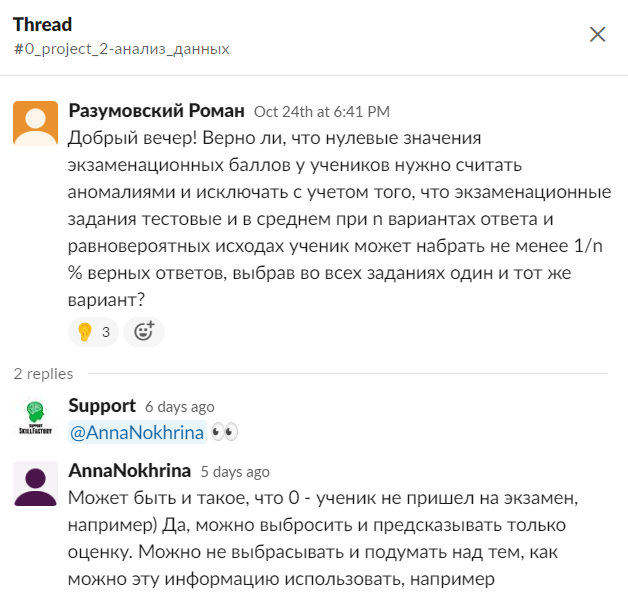

In [180]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               389 non-null    object 
 1   sex                  389 non-null    object 
 2   age                  389 non-null    int64  
 3   address              374 non-null    object 
 4   famsize              362 non-null    object 
 5   Pstatus              344 non-null    object 
 6   Medu                 386 non-null    float64
 7   Fedu                 365 non-null    float64
 8   Mjob                 370 non-null    object 
 9   Fjob                 353 non-null    object 
 10  reason               372 non-null    object 
 11  guardian             358 non-null    object 
 12  traveltime           361 non-null    float64
 13  studytime            382 non-null    float64
 14  failures             367 non-null    float64
 15  schoolsup            380 non-null    obj

Выполним анализ распределений номинативных переменных, заполним пропуски значением Missing, проанализируем их влияние на score_pos.
Начиная с pandas 1.1 в groupby появилась возможность анализа пропусков (dropna = False), но пока не удалось перейти на указанную версию, поэтому используются подобные заполнения пропусков

In [181]:
# Формируем справочники номинативных и количественных переменных
nominal_cols = [col for col in stud_math.columns if stud_math.dtypes[col] == 'object']
print(nominal_cols)
interval_cols = [col for col in stud_math.columns if ((stud_math.dtypes[col] != 'object') & (col != 'score') & (col != 'score_pos'))]
print(interval_cols)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'studytime, granular', 'famrel', 'freetime', 'goout', 'health', 'absences']


Пропуски school в количестве 0 шт.
Пропуски sex в количестве 0 шт.
Пропуски address в количестве 15 шт.
Пропуски famsize в количестве 27 шт.
Пропуски Pstatus в количестве 45 шт.
Пропуски Mjob в количестве 19 шт.
Пропуски Fjob в количестве 36 шт.
Пропуски reason в количестве 17 шт.
Пропуски guardian в количестве 31 шт.
Пропуски schoolsup в количестве 9 шт.
Пропуски famsup в количестве 38 шт.
Пропуски paid в количестве 39 шт.
Пропуски activities в количестве 14 шт.
Пропуски nursery в количестве 15 шт.
Пропуски higher в количестве 20 шт.
Пропуски internet в количестве 34 шт.
Пропуски romantic в количестве 31 шт.


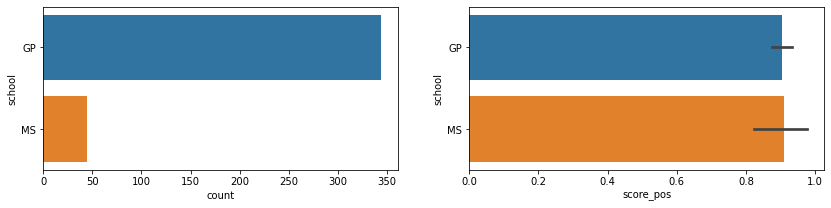

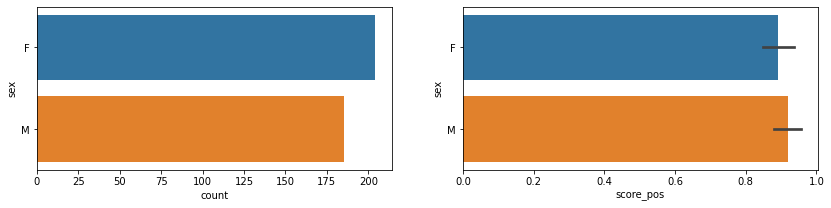

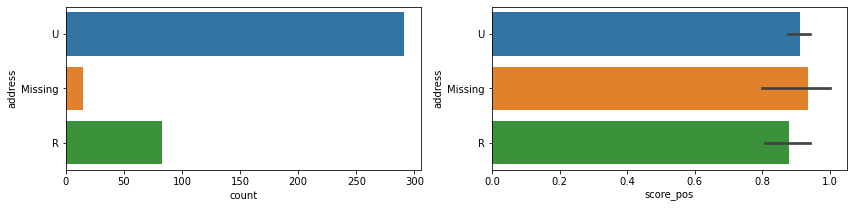

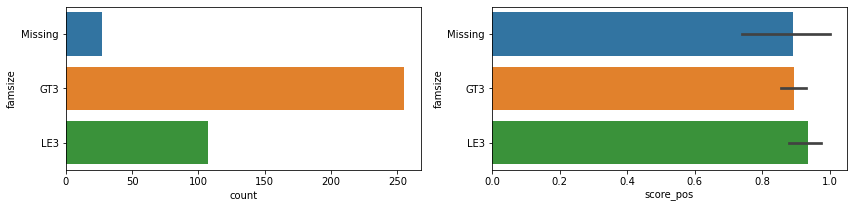

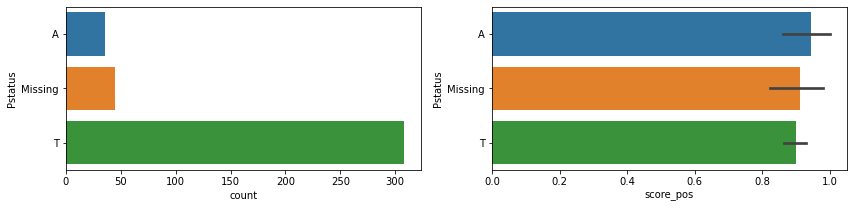

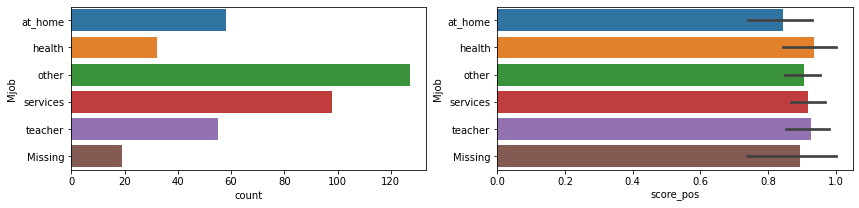

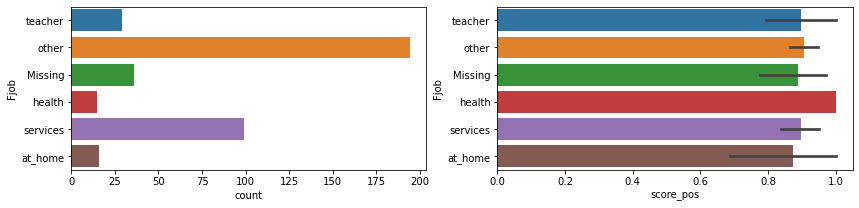

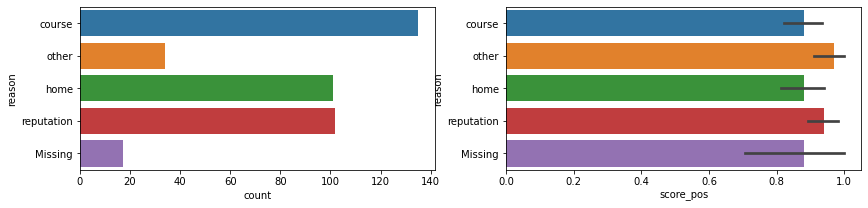

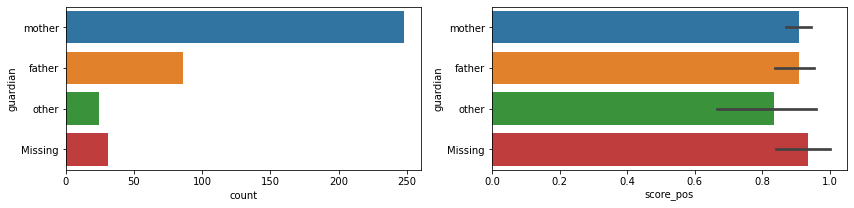

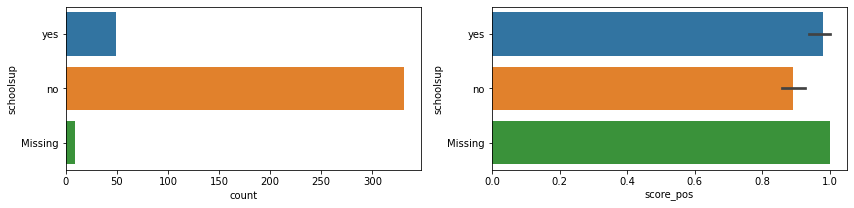

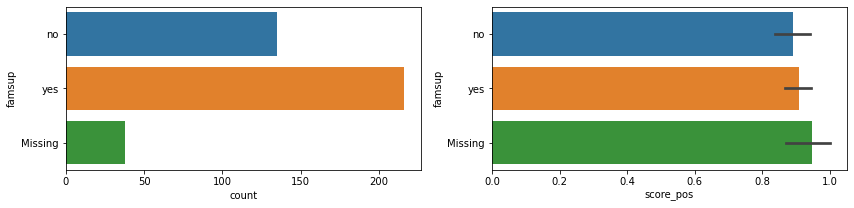

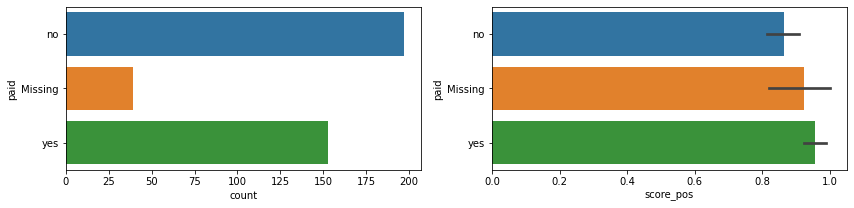

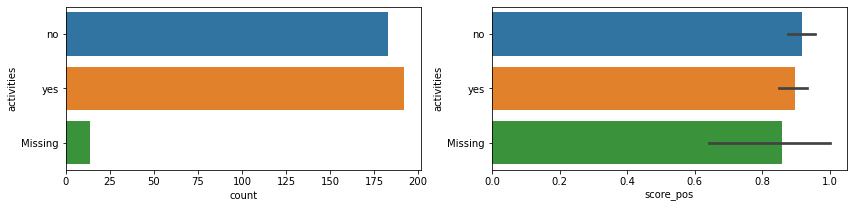

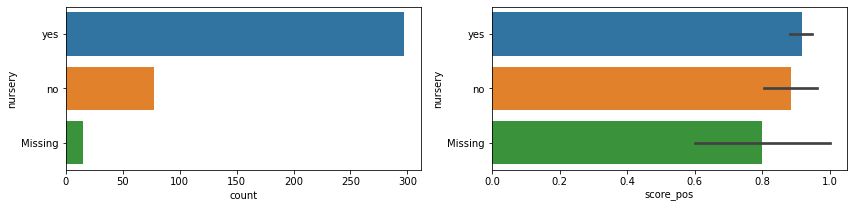

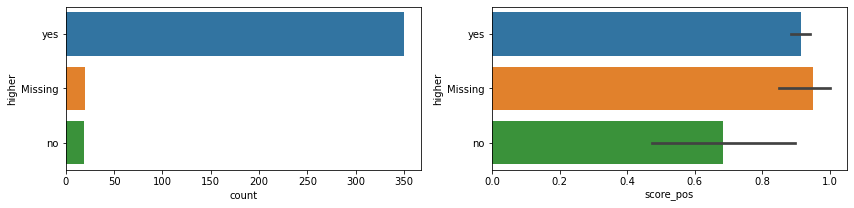

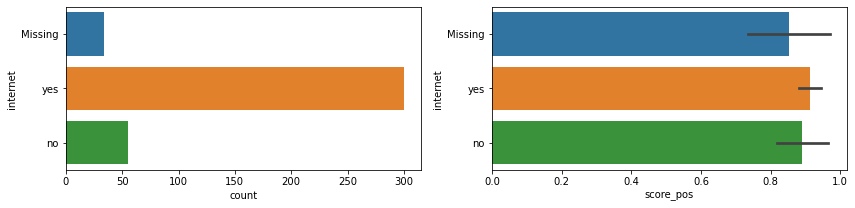

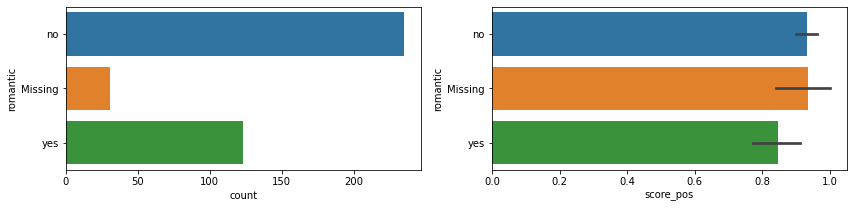

In [182]:
def analyze_nominal(data, var, response):
    '''Заполнение пропусков в номинативных переменных и визуализация распределений'''
    print('Пропуски', var, 'в количестве', data[data[var].isnull()].shape[0], 'шт.')
    data[[var]] = data[[var]].fillna(value = 'Missing')
    fig, ax = plt.subplots(ncols=2, figsize = (14, 3))
    sns.countplot(y = var, data = data, ax=ax[0])
    sns.barplot(x = response, y = var, data=data, ax=ax[1])

for col in nominal_cols:
    analyze_nominal(stud_math, col, 'score_pos')

Выполним анализ распределений количественных переменных, заполним пропуски значением -1, проанализируем их влияние на score_pos

Пропуски age в количестве 0 шт.
Пропуски Medu в количестве 3 шт.
Пропуски Fedu в количестве 24 шт.
Пропуски traveltime в количестве 28 шт.
Пропуски studytime в количестве 7 шт.
Пропуски failures в количестве 22 шт.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Пропуски studytime, granular в количестве 7 шт.
Пропуски famrel в количестве 27 шт.
Пропуски freetime в количестве 9 шт.
Пропуски goout в количестве 7 шт.
Пропуски health в количестве 15 шт.
Пропуски absences в количестве 11 шт.


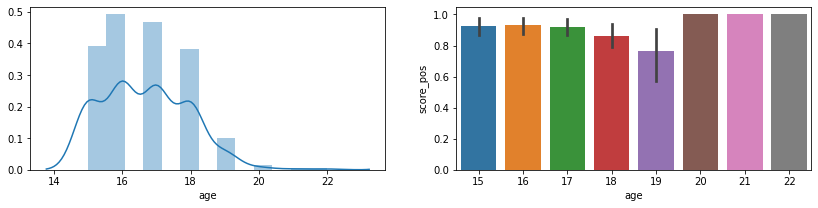

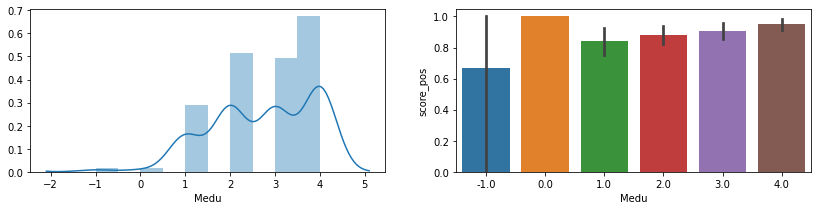

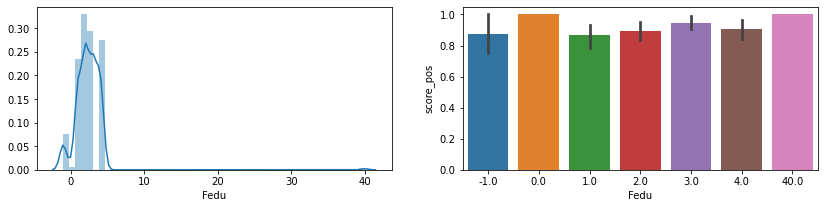

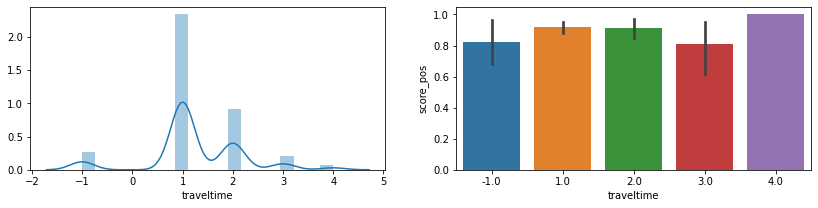

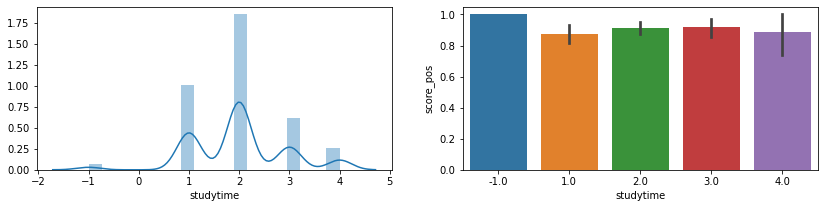

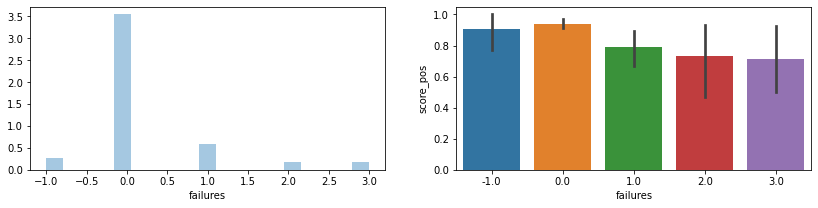

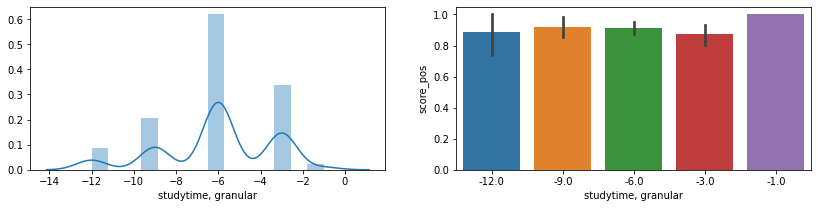

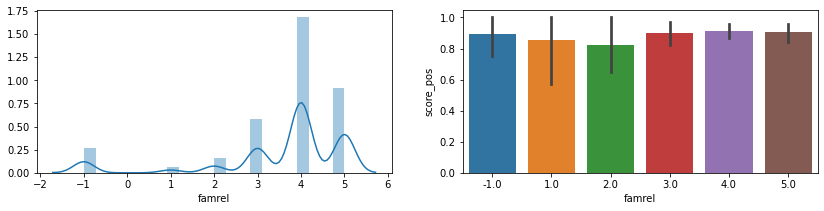

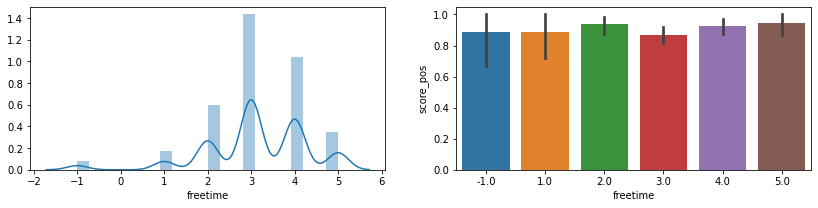

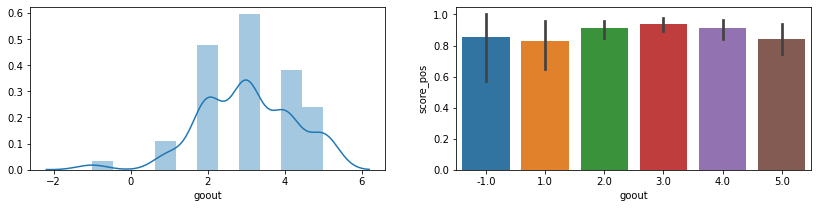

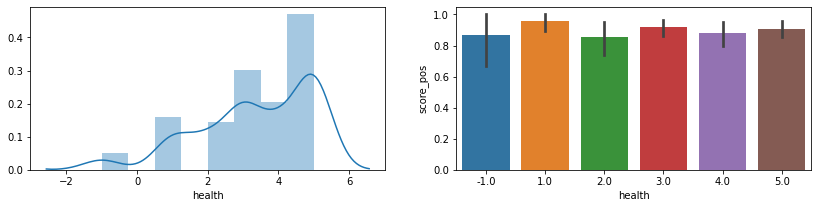

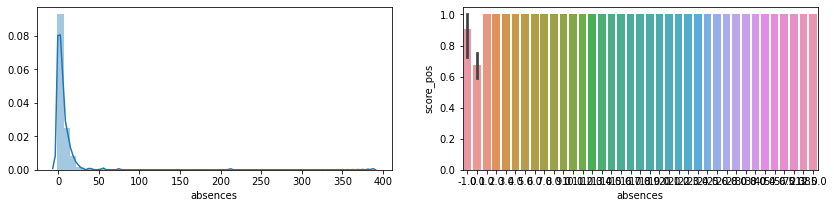

In [183]:
def analyze_interval(data, var, response):
    '''Заполнение пропусков в количественных переменных и визуализация распределений'''
    print('Пропуски', var, 'в количестве', data[data[var].isnull()].shape[0], 'шт.')
    data[[var]] = data[[var]].fillna(value = -1)
    
    fig, ax = plt.subplots(ncols=2, figsize = (14, 3))
    sns.distplot(data[var], ax=ax[0])
    sns.barplot(y = response, x = var, data=data, ax=ax[1])

for col in interval_cols:
    analyze_interval(stud_math, col, 'score_pos')

Как видно выше, при absences > 0 выделяются 268 наблюдений из 389 (69% выборки) с score_pos = 1, поэтому есть смысл сегментировать выборку по указанному критерию и проводить дальнейший анализ на подвыборках.

Количество наблюдений в stud_math_0: 121  На данной выборке моделируется score_pos
Количество наблюдений в stud_math_1: 268  На данной выборке моделируется score
Количество наблюдений в stud_math_2: 84  На данной выборке моделируется score


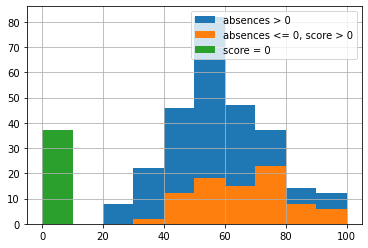

In [345]:
stud_math_0 = stud_math[-(stud_math['absences'] > 0)]
print('Количество наблюдений в stud_math_0:',stud_math_0.shape[0],' На данной выборке моделируется score_pos')
stud_math_1 = stud_math[stud_math['absences'] > 0]
print('Количество наблюдений в stud_math_1:',stud_math_1.shape[0],' На данной выборке моделируется score')
stud_math_2 = stud_math[(stud_math['score'] > 0) & -(stud_math['absences'] > 0)]
print('Количество наблюдений в stud_math_2:',stud_math_2.shape[0],' На данной выборке моделируется score')

stud_math_1.score.hist(range = (0, 100), label = 'absences > 0')
stud_math_2.score.hist(range = (0, 100), label = 'absences <= 0, score > 0')
stud_math[stud_math['score'] == 0].score.hist(range = (0, 100), label = 'score = 0')
plt.legend();

Сначала проведем анализ в выборке stud_math_1. В ней нужно сразу моделировать score.

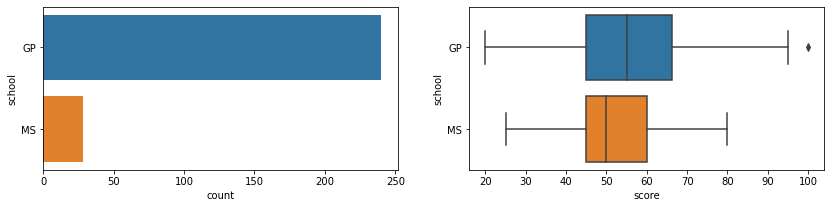

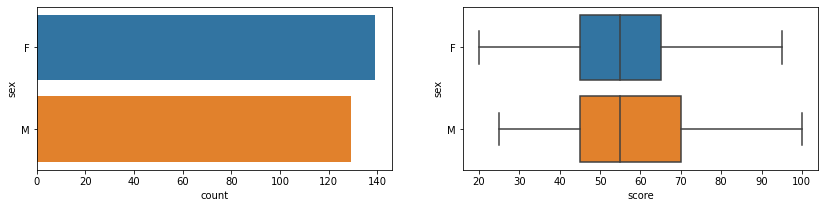

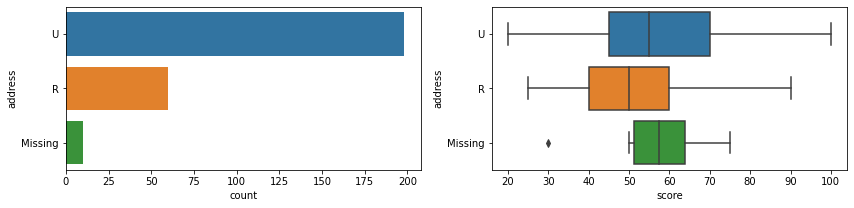

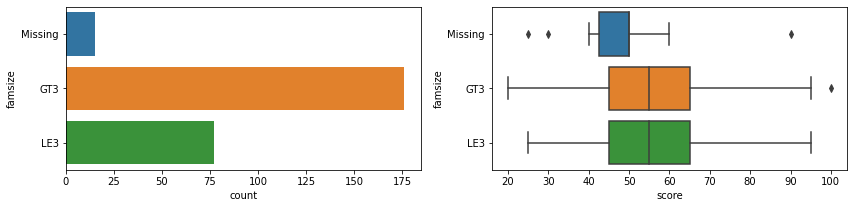

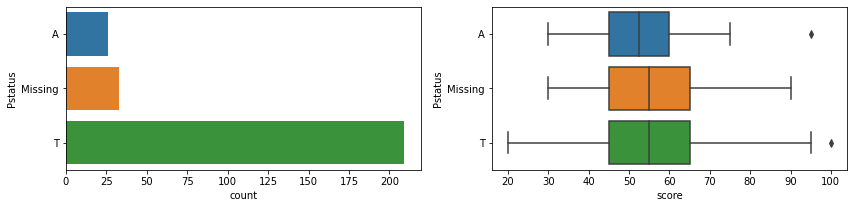

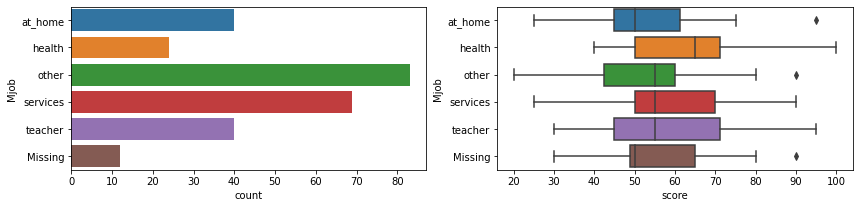

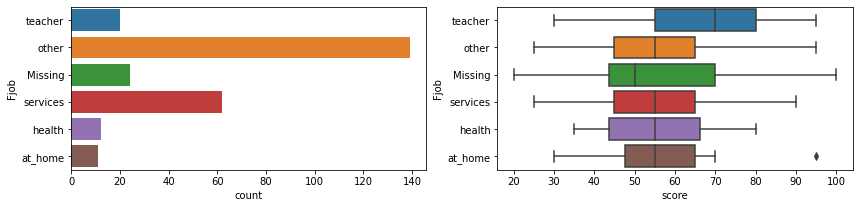

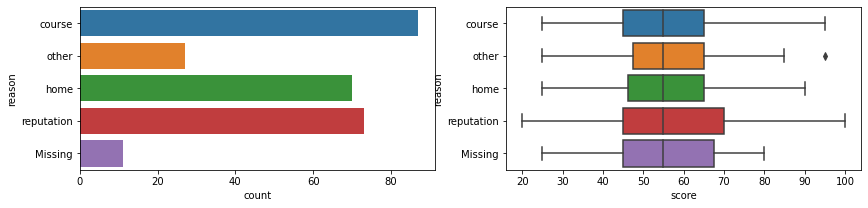

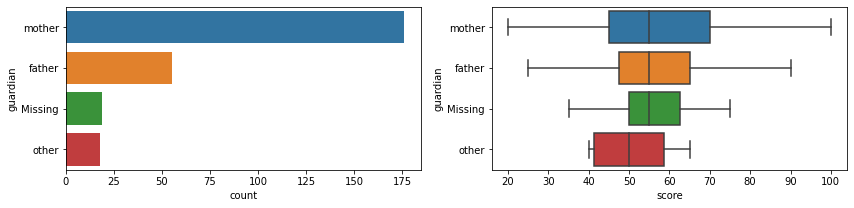

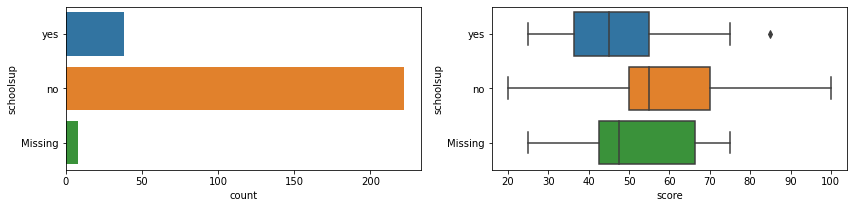

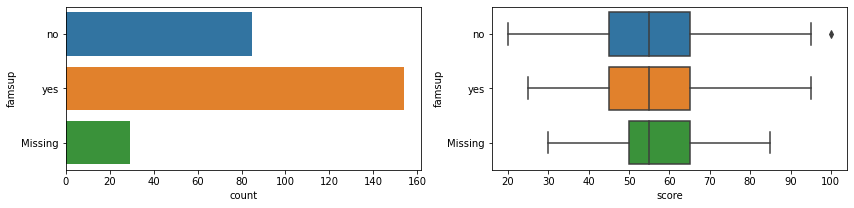

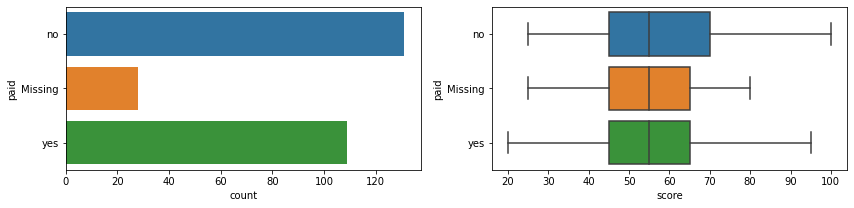

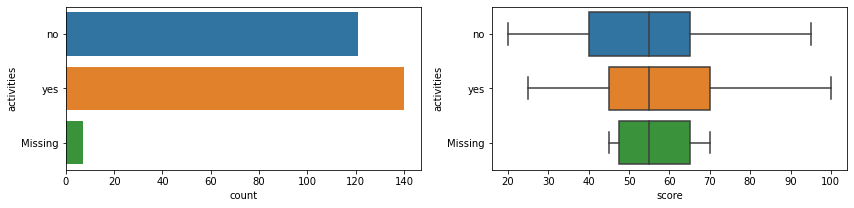

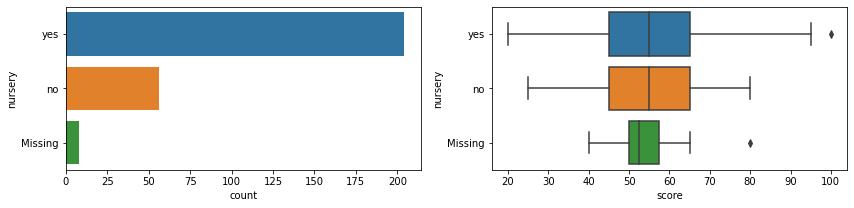

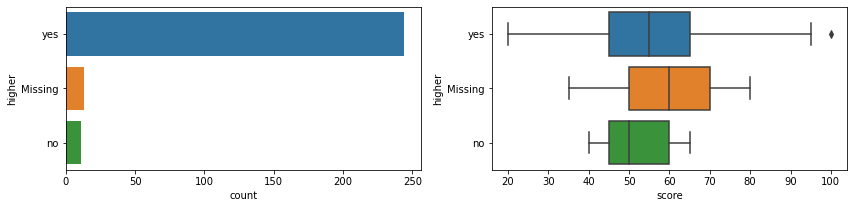

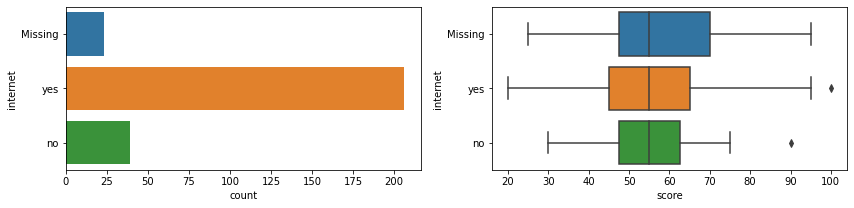

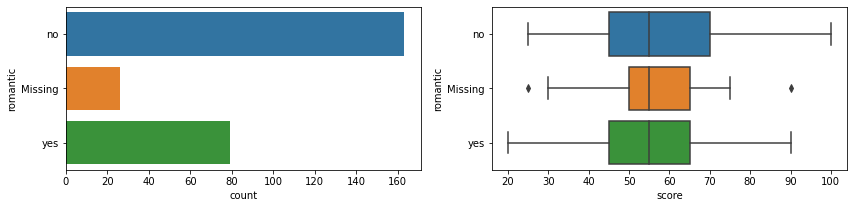

In [147]:
def get_boxplot(data, var, response):
    fig, ax = plt.subplots(ncols=2, figsize = (14, 3))
    sns.countplot(y = var, data = data, ax=ax[0])
    sns.boxplot(x=response, y=var, data=data, ax=ax[1])
    
for col in nominal_cols:
    get_boxplot(stud_math_1, col, 'score')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


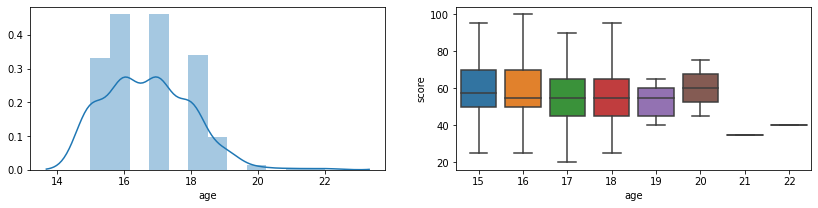

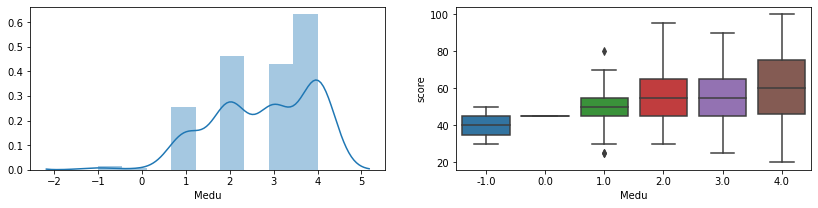

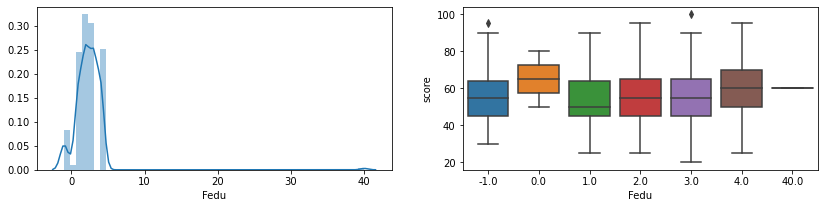

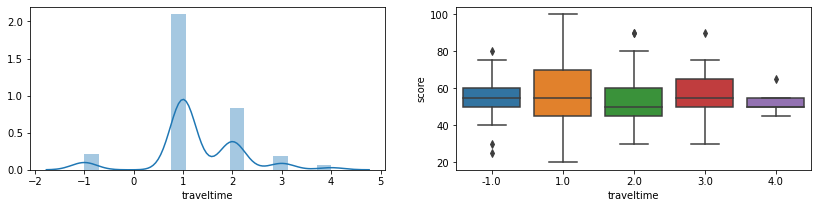

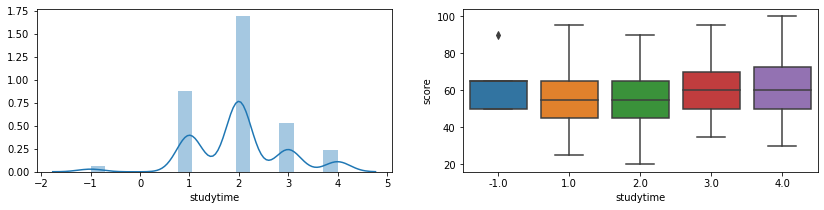

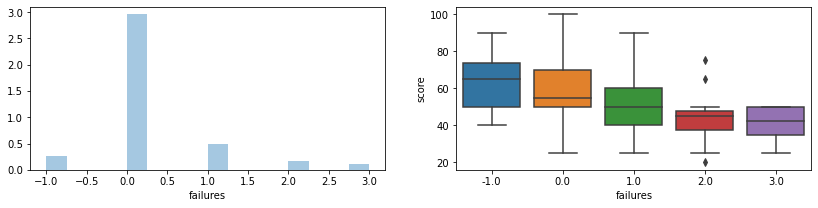

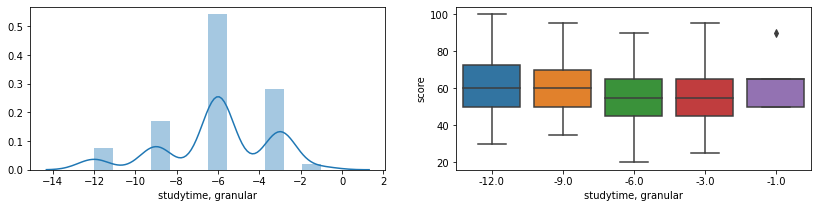

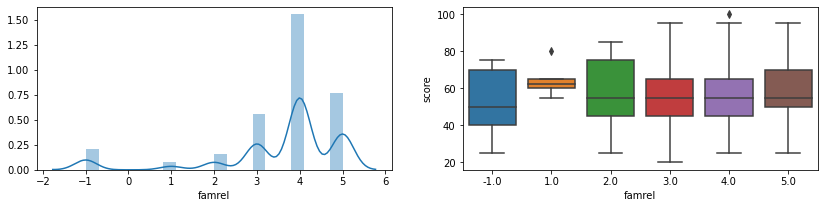

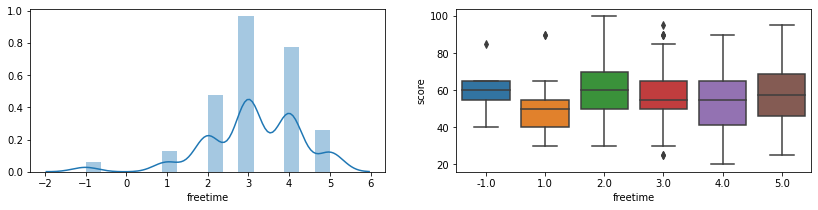

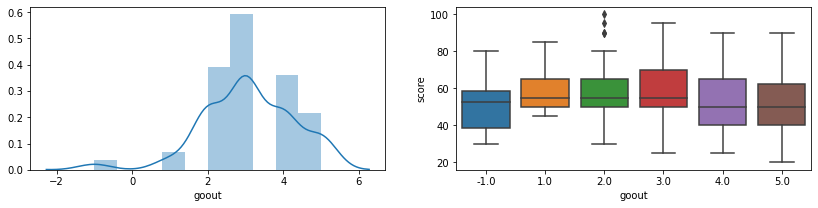

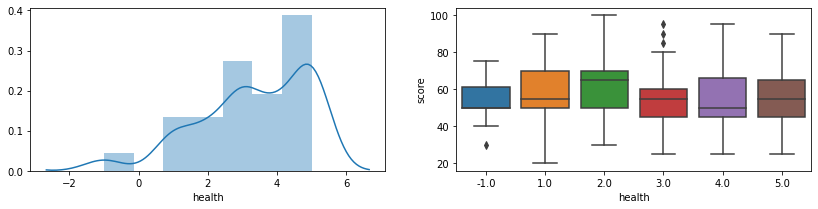

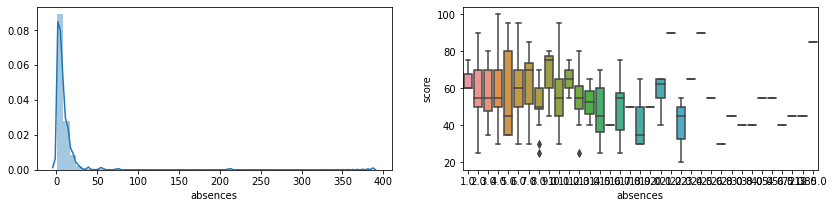

In [148]:
def get_boxplot_interval(data, var, response):
    fig, ax = plt.subplots(ncols=2, figsize = (14, 3))
    sns.distplot(data[var], ax=ax[0])
    sns.boxplot(y=response, x=var, data=data, ax=ax[1])

for col in interval_cols:
    get_boxplot_interval(stud_math_1, col, 'score')

Исключим/ограничим выбросы на основании описаний переменных

Границы выбросов age [13.0, 21.0]
Границы выбросов absences [-7.5, 20.5]


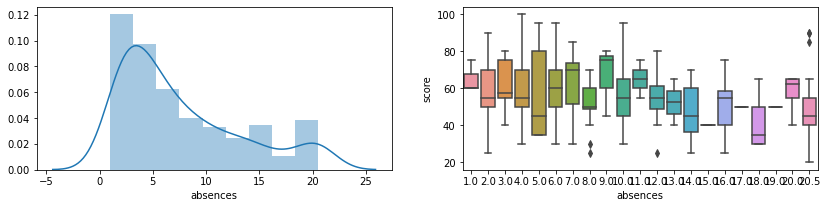

In [185]:
print('Границы выбросов age', get_borders(stud_math_1['age']))
stud_math_1 = stud_math_1[stud_math_1['age'] < get_borders(stud_math_1['age'])[1]]
stud_math_1 = stud_math_1[stud_math_1['Fedu'] <= 4]
print('Границы выбросов absences', get_borders(stud_math_1['absences']))
stud_math_1[stud_math_1['absences'] < get_borders(stud_math_1['absences'])[1]].shape[0]
stud_math_1['absences'] = stud_math_1['absences'] \
    .apply(lambda x : x if x < get_borders(stud_math_1['absences'])[1] else get_borders(stud_math_1['absences'])[1])
get_boxplot_interval(stud_math_1, 'absences', 'score')

Исследуем корреляции факторов со score. Для номинативных признаков сформируем переменные со средними значениями score в зависимости от значений номинативных переменных.

In [186]:
def col_score(data, col, response):
    stat = data.groupby(col).agg({response:'mean'})
    stat.columns = [col + '_score']
    new_data = data.merge(stat, left_on = col, right_index = True)
    #print(col, new_data.shape[0])
    return new_data

for col in nominal_cols:
    stud_math_1 = col_score(stud_math_1, col, 'score')

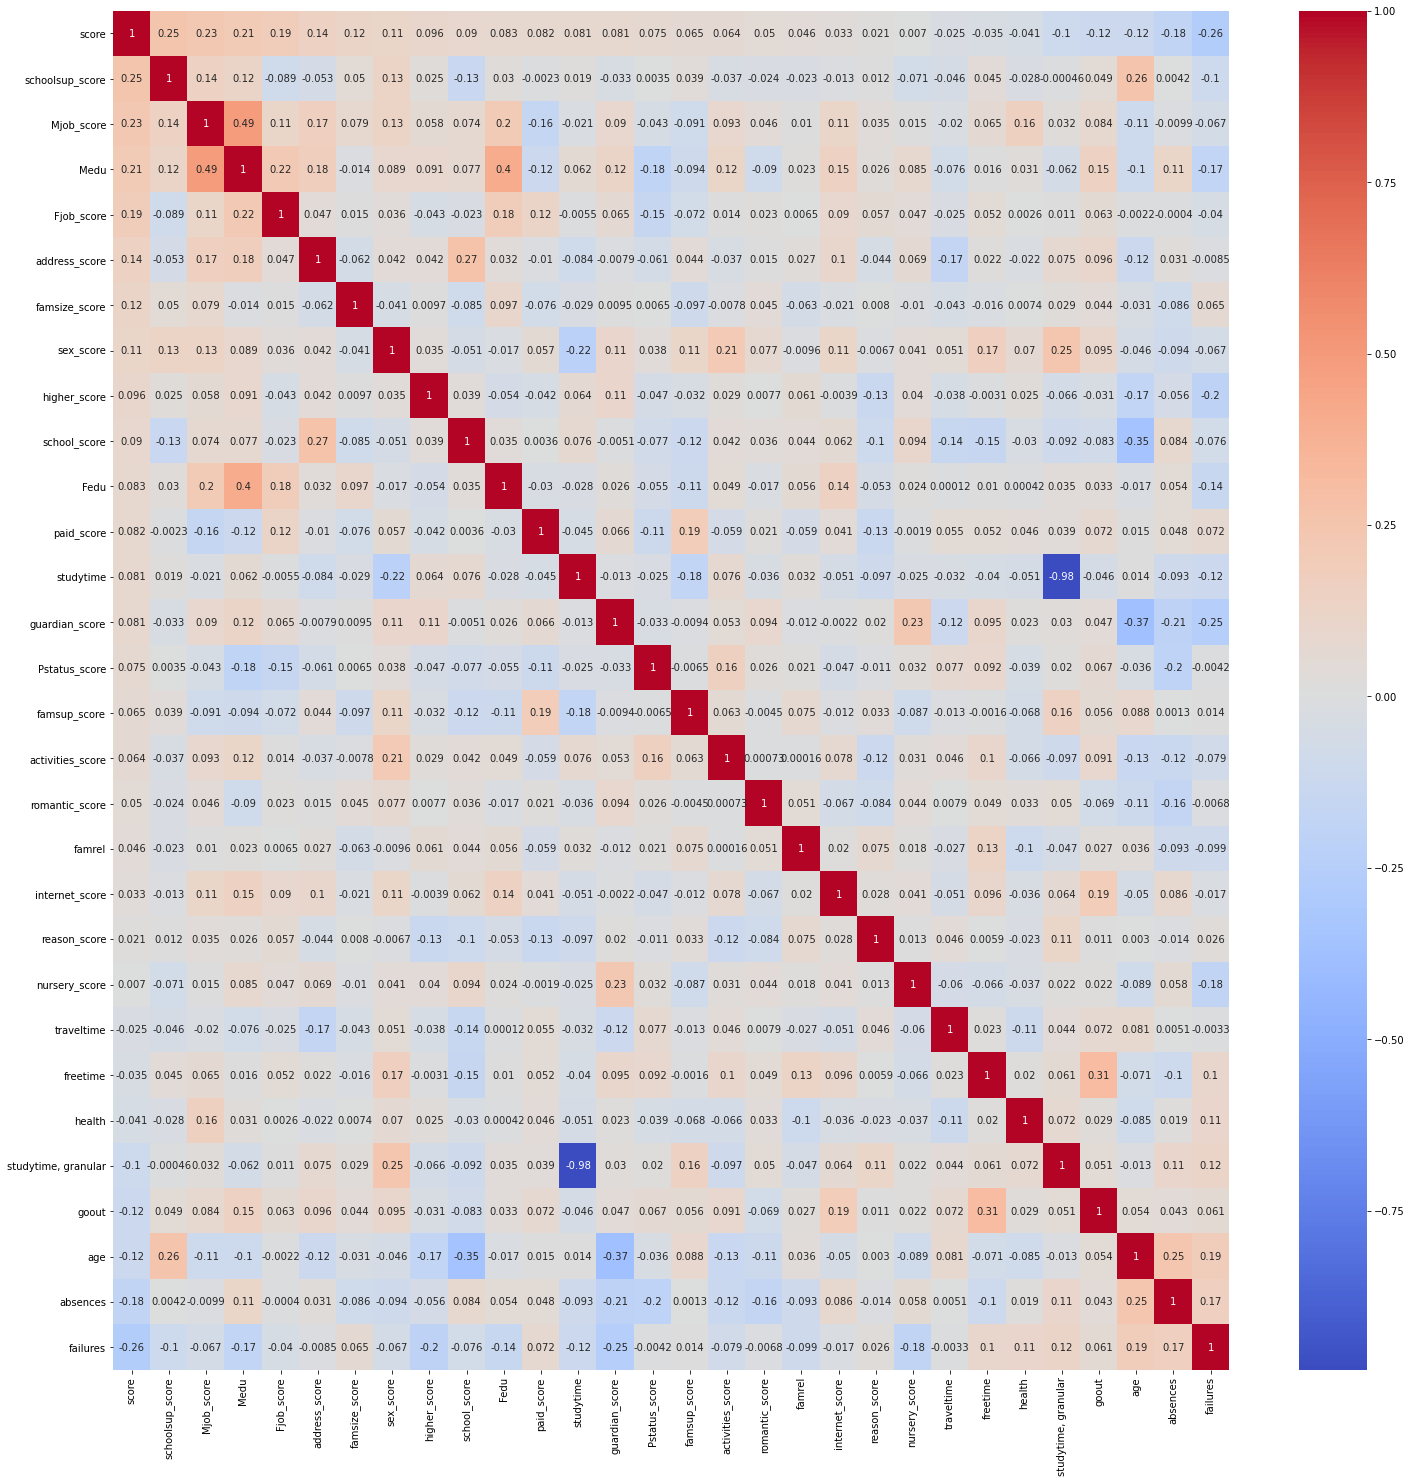

In [187]:
nominal_score_cols = [col for col in stud_math_1.columns if '_score' in col]
corr_cols = ['score'] + nominal_score_cols + interval_cols
correlations = stud_math_1[corr_cols].corr()
importance = correlations['score'].sort_values(ascending = False).index
correlations = correlations.reindex(index = importance, columns = importance)

fig, ax = plt.subplots(figsize = (25,25))
ax = sns.heatmap(correlations, annot = True, cmap = 'coolwarm')

В качестве канидатов для модели можно взять переменные, имеющие корреляцию со score по модулю не менее 15%. Рассмотрим более подробно их матрицу корреляций.

In [247]:
corrs = correlations['score'].apply(lambda x : abs(x)).sort_values(ascending = False)
print(corrs)
top_corrs = list(corrs[corrs > 0.15].index)

score                  1.000000
failures               0.263726
schoolsup_score        0.249098
Mjob_score             0.227896
Medu                   0.209100
Fjob_score             0.186716
absences               0.180874
address_score          0.143371
famsize_score          0.118847
age                    0.118479
goout                  0.117482
sex_score              0.112003
studytime, granular    0.101663
higher_score           0.096407
school_score           0.090491
Fedu                   0.083288
paid_score             0.082194
studytime              0.081134
guardian_score         0.080779
Pstatus_score          0.075475
famsup_score           0.064690
activities_score       0.064486
romantic_score         0.049847
famrel                 0.046258
health                 0.040959
freetime               0.034938
internet_score         0.033373
traveltime             0.025029
reason_score           0.020511
nursery_score          0.006967
Name: score, dtype: float64


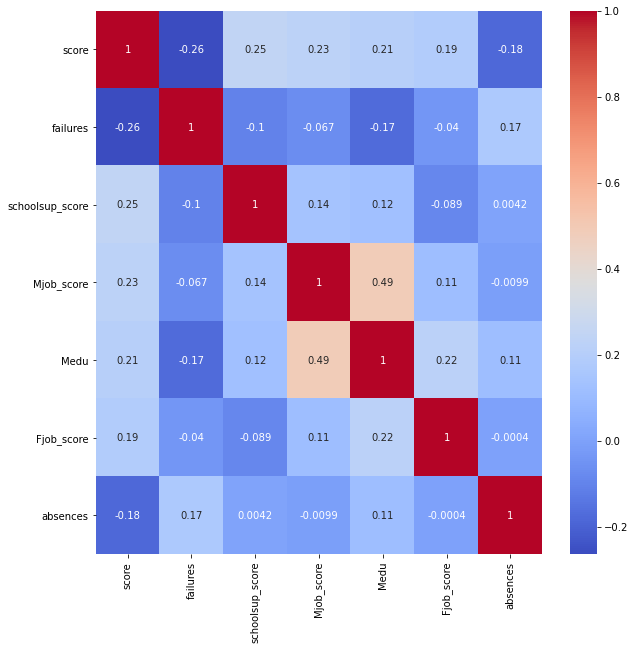

In [248]:
top_correlations = correlations[top_corrs].loc[top_corrs]

fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(top_correlations, annot = True, cmap = 'coolwarm')

Между работой и образованием матери наблюдается корреляция 49%. 
Чем выше образование матери, тем выше балл ребенка. 
У домохозяек образование смещено влево, балл детей ниже среднего. У преподавателей и врачей образование смещено вправо, балл детей выше среднего.
Нужно оставить либо одну из 2 переменных, либо сформировать кросс-переменную.

Корреляции между failures и absences, а также между Medu и Fjob могут привести к увеличению погрешностей коэффициентов регрессии. Данный эффект стоит проверить уже на этапе построения регрессии.

In [244]:
stud_math_1.pivot_table(values = 'score', index = ['Mjob','Medu'],aggfunc=[np.mean,len])

mean   len
                   score score
Mjob     Medu                 
Missing   1.0  65.000000   1.0
          2.0  50.000000   3.0
          3.0  46.666667   3.0
          4.0  64.000000   5.0
at_home   0.0  45.000000   1.0
          1.0  53.235294  17.0
          2.0  55.937500  16.0
          3.0  44.000000   5.0
          4.0  30.000000   1.0
health    1.0  40.000000   1.0
          2.0  42.500000   2.0
          3.0  55.000000   3.0
          4.0  66.666667  18.0
other    -1.0  30.000000   1.0
          1.0  45.666667  15.0
          2.0  55.000000  27.0
          3.0  55.416667  24.0
          4.0  51.000000  15.0
services -1.0  50.000000   1.0
          1.0  56.666667   3.0
          2.0  58.500000  20.0
          3.0  57.307692  26.0
          4.0  62.941176  17.0
teacher   3.0  50.000000   2.0
          4.0  59.736842  38.0

Выполним аналогичный анализ для выборки stud_math_2

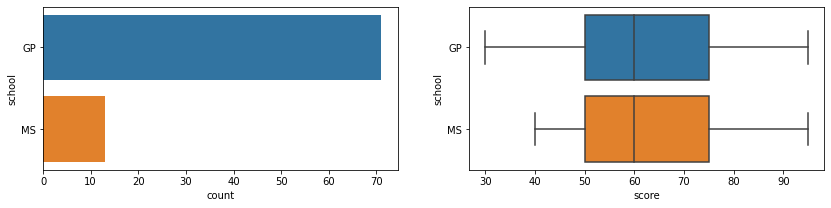

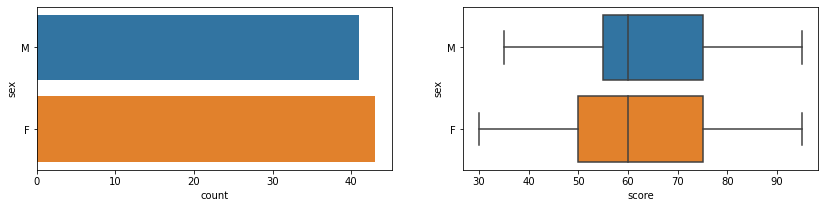

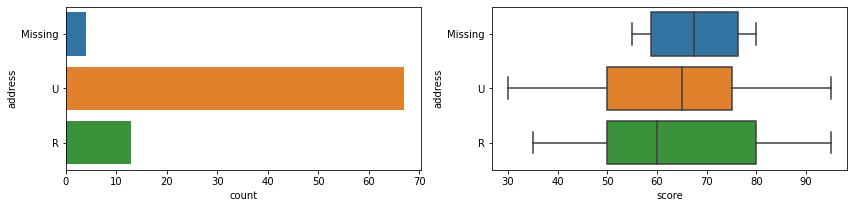

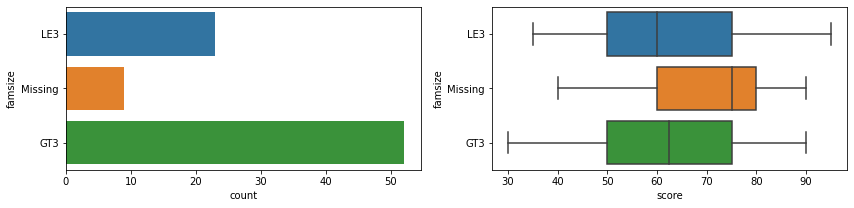

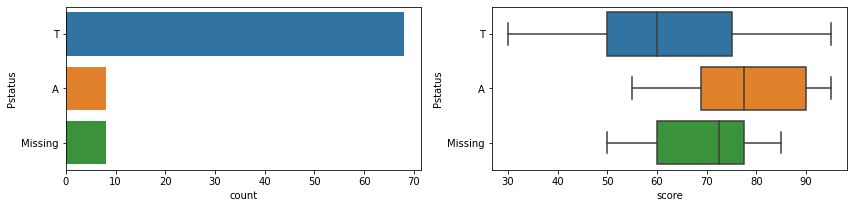

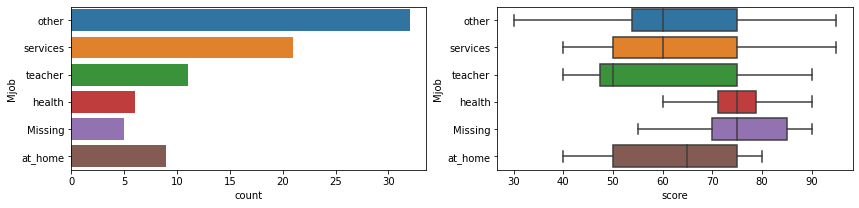

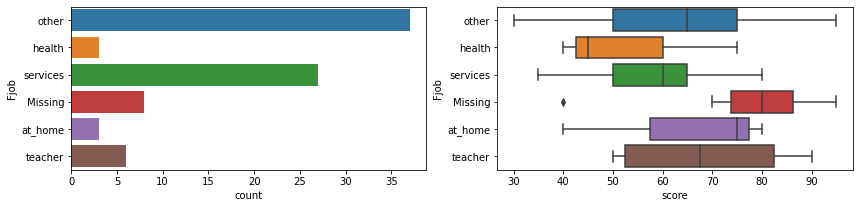

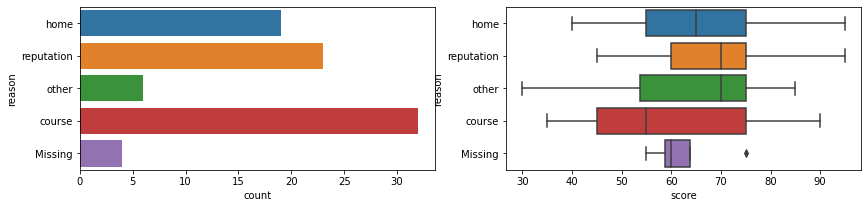

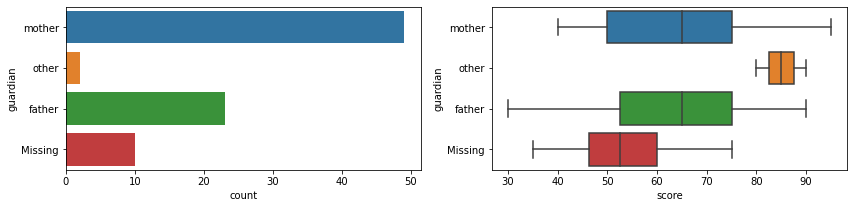

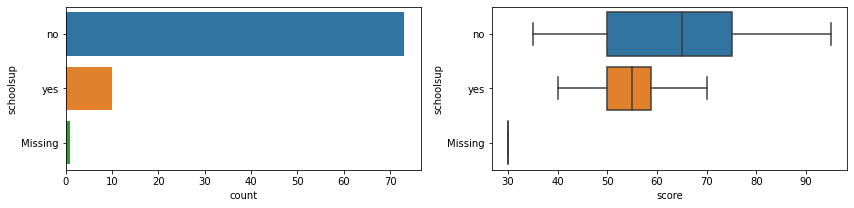

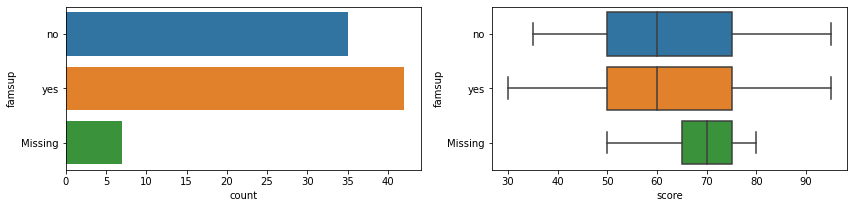

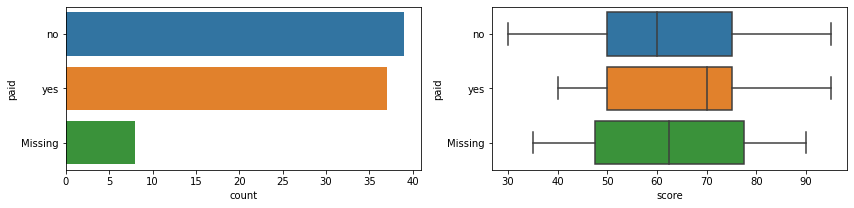

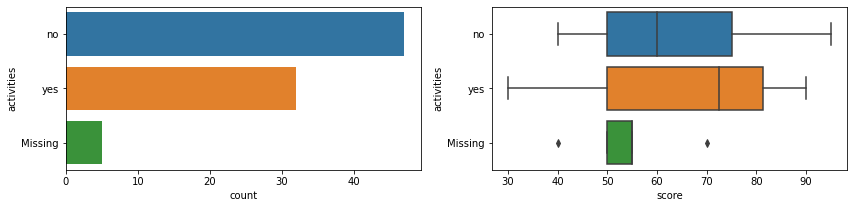

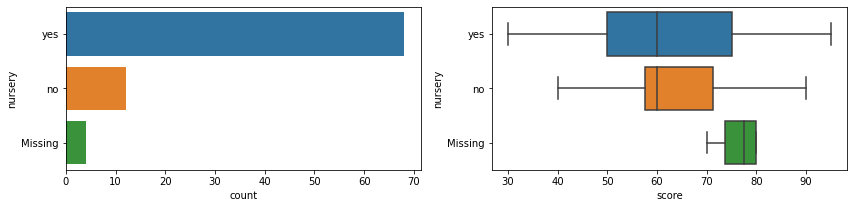

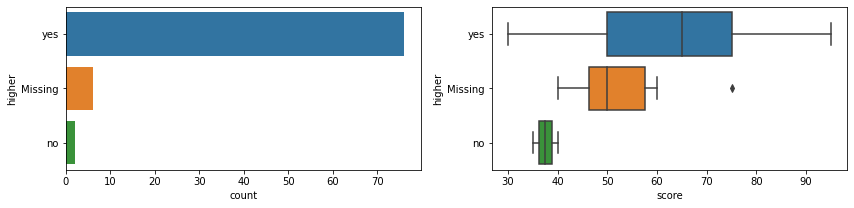

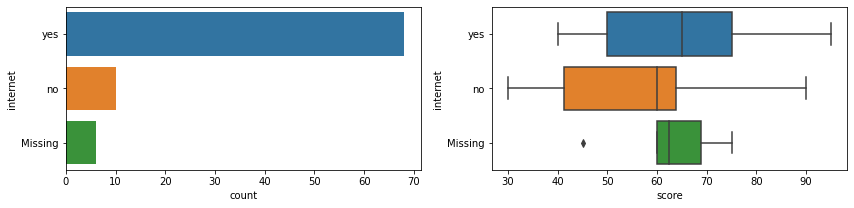

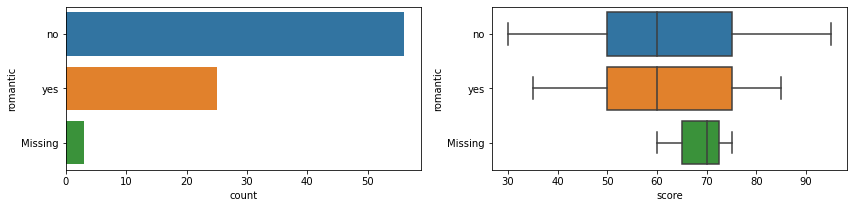

In [257]:
for col in nominal_cols:
    get_boxplot(stud_math_2, col, 'score')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


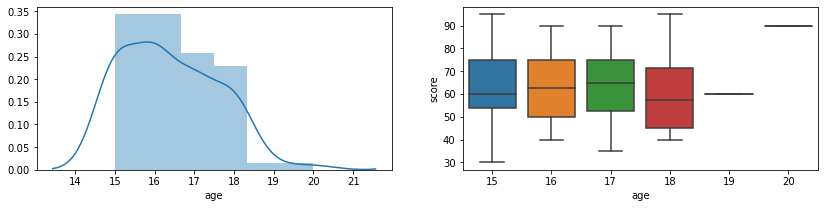

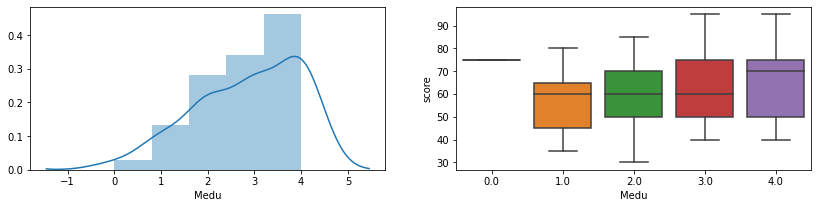

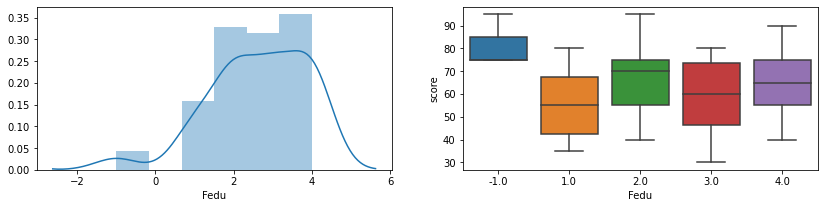

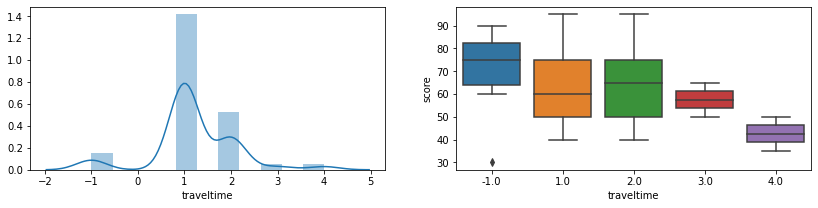

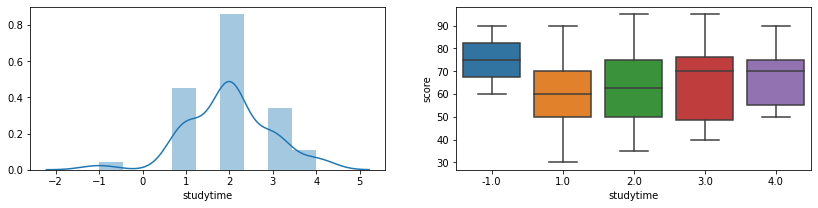

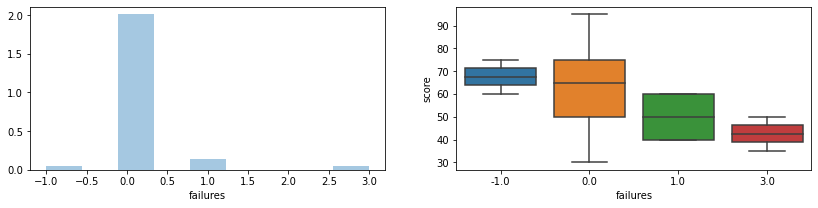

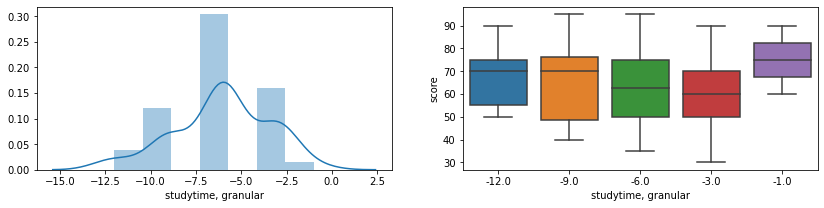

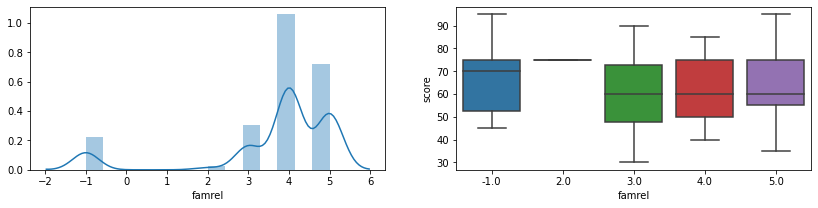

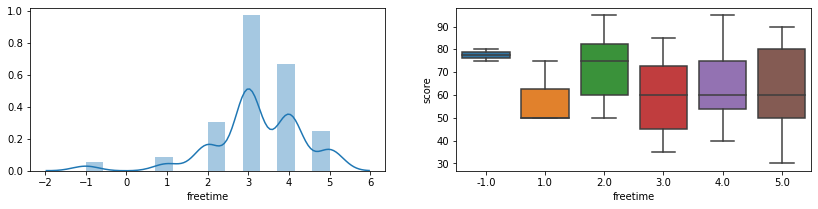

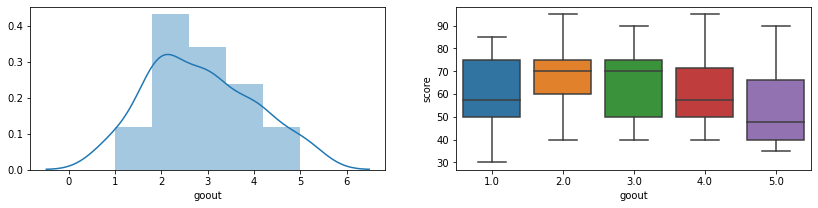

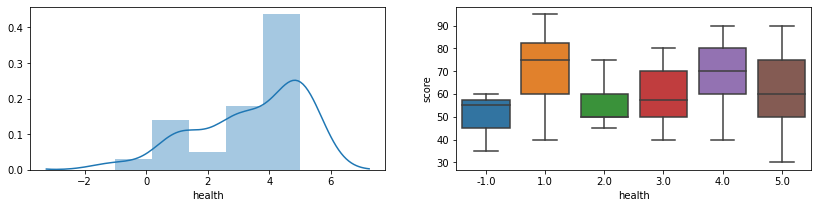

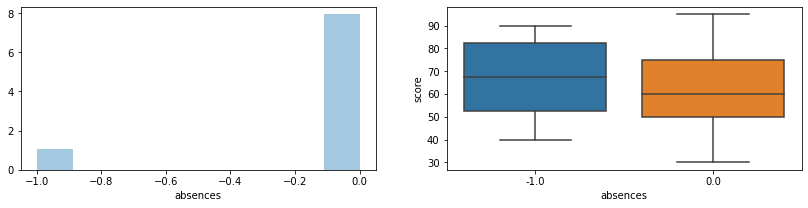

In [258]:
for col in interval_cols:
    get_boxplot_interval(stud_math_2, col, 'score')

In [259]:
print('Границы выбросов age', get_borders(stud_math_2['age']))
stud_math_2 = stud_math_2[stud_math_2['age'] < get_borders(stud_math_2['age'])[1]]

Границы выбросов age [12.0, 20.0]


In [260]:
for col in nominal_cols:
    stud_math_2 = col_score(stud_math_2, col, 'score')

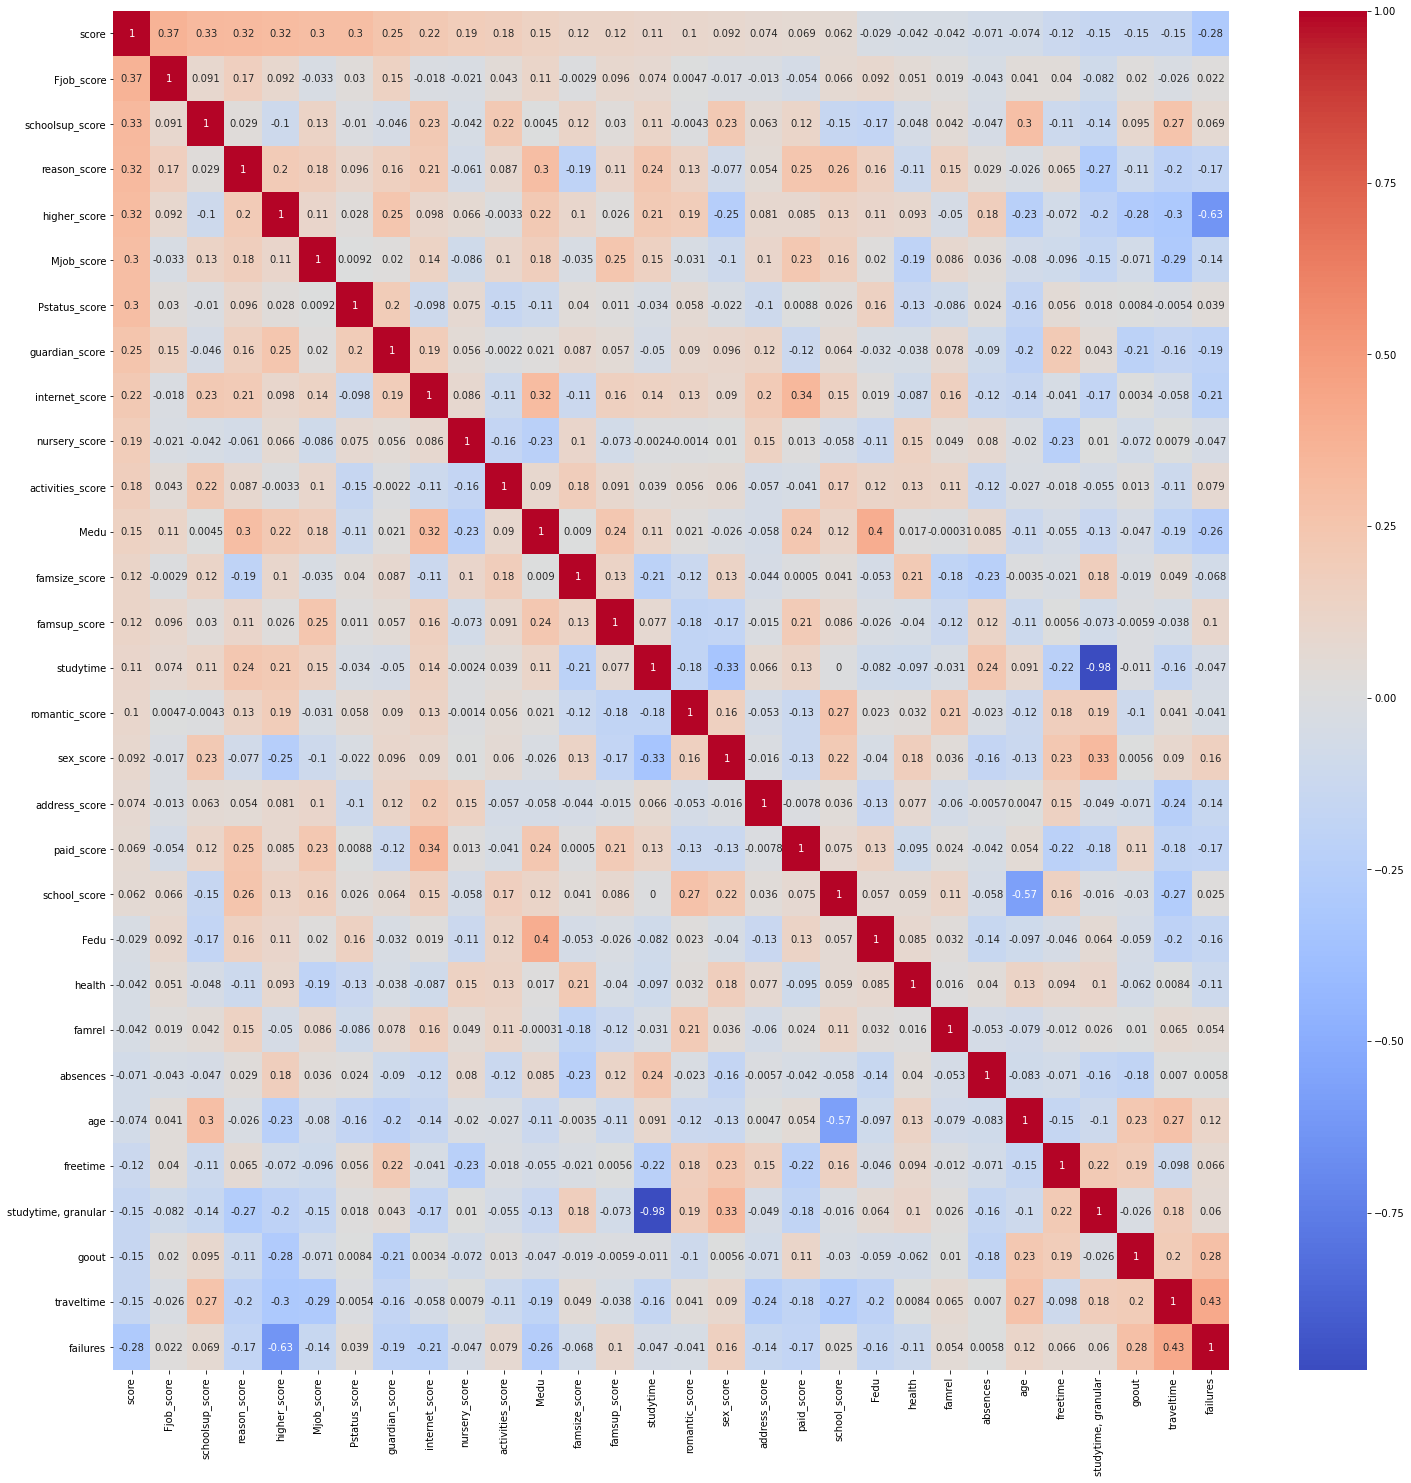

In [265]:
nominal_score_cols = [col for col in stud_math_2.columns if '_score' in col]
corr_cols = ['score'] + nominal_score_cols + interval_cols
correlations_2 = stud_math_2[corr_cols].corr()
importance = correlations_2['score'].sort_values(ascending = False).index
correlations_2 = correlations_2.reindex(index = importance, columns = importance)

fig, ax = plt.subplots(figsize = (25,25))
ax = sns.heatmap(correlations_2, annot = True, cmap = 'coolwarm')

score                  1.000000
Fjob_score             0.367191
schoolsup_score        0.333388
reason_score           0.322881
higher_score           0.318025
Mjob_score             0.302555
Pstatus_score          0.302388
failures               0.284380
guardian_score         0.254385
internet_score         0.219592
nursery_score          0.191955
activities_score       0.175611
traveltime             0.151537
goout                  0.151002
Medu                   0.147650
studytime, granular    0.146088
famsize_score          0.119563
famsup_score           0.119209
freetime               0.115647
studytime              0.106867
romantic_score         0.101888
sex_score              0.092457
age                    0.074130
address_score          0.073768
absences               0.071247
paid_score             0.068685
school_score           0.062269
famrel                 0.042224
health                 0.041571
Fedu                   0.029210
Name: score, dtype: float64


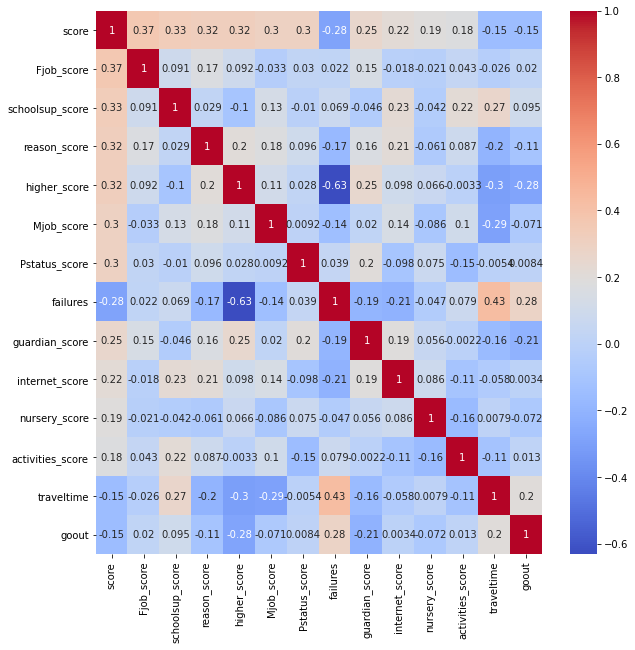

In [266]:
corrs_2 = correlations_2['score'].apply(lambda x : abs(x)).sort_values(ascending = False)
print(corrs_2)
top_corrs_2 = list(corrs_2[corrs_2 > 0.15].index)

top_correlations_2 = correlations_2[top_corrs_2].loc[top_corrs_2]

fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(top_correlations_2, annot = True, cmap = 'coolwarm')

По сравнению со stud_math_1 порог в 15% корреляции преодолело вдвое больше переменных. Вероятно это связано с эффектом переобучения ввиду меньшей выборки stud_math_2 (84 против 268) и отсутствием валидационной выборки. Нужно либо использовать модель, построенную на stud_math_1, либо обучить модель на объединении stud_math_1 и stud_math_2.

Остается изучить зависимости на выборке stud_math_0 применительно к задаче классификации score_pos.

Пропуски school в количестве 0 шт.
Пропуски sex в количестве 0 шт.
Пропуски address в количестве 0 шт.
Пропуски famsize в количестве 0 шт.
Пропуски Pstatus в количестве 0 шт.
Пропуски Mjob в количестве 0 шт.
Пропуски Fjob в количестве 0 шт.
Пропуски reason в количестве 0 шт.
Пропуски guardian в количестве 0 шт.
Пропуски schoolsup в количестве 0 шт.
Пропуски famsup в количестве 0 шт.
Пропуски paid в количестве 0 шт.
Пропуски activities в количестве 0 шт.
Пропуски nursery в количестве 0 шт.
Пропуски higher в количестве 0 шт.
Пропуски internet в количестве 0 шт.
Пропуски romantic в количестве 0 шт.


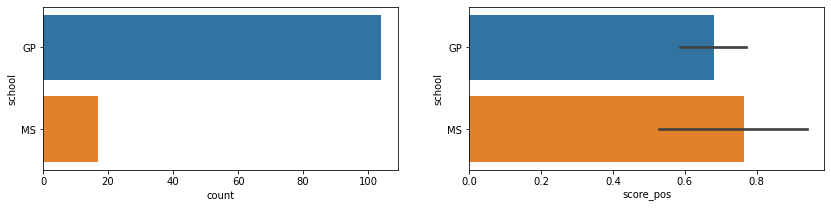

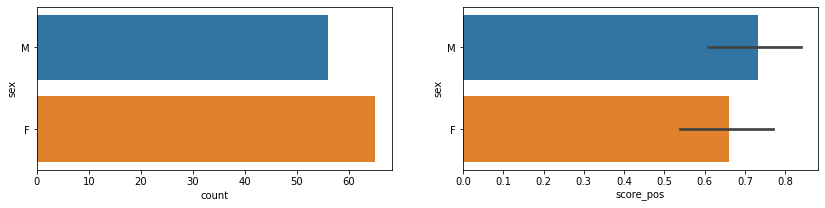

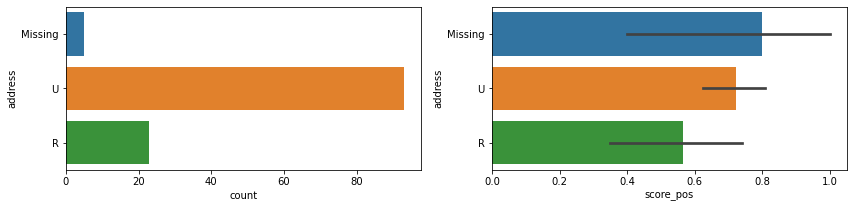

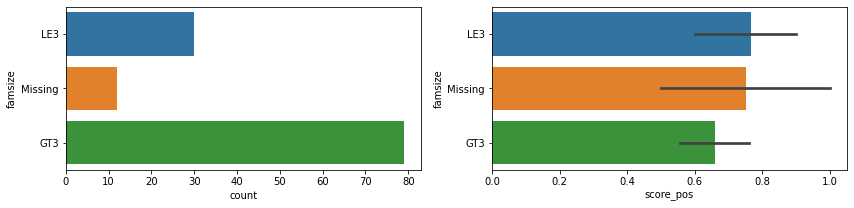

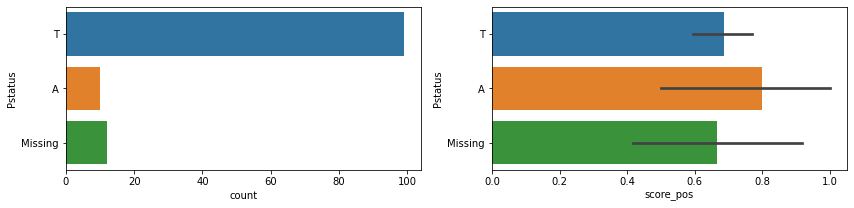

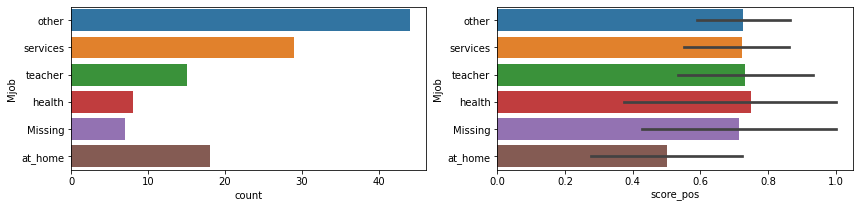

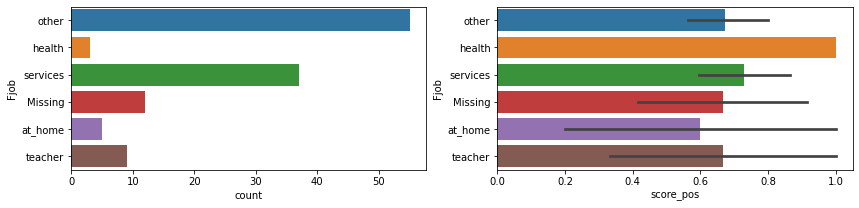

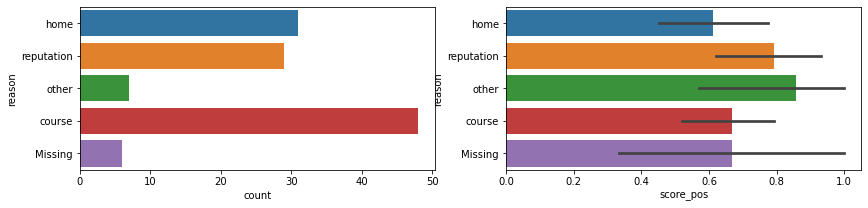

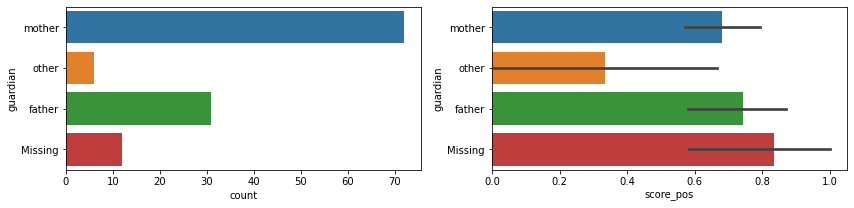

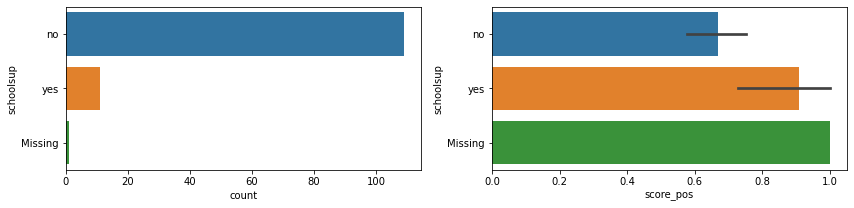

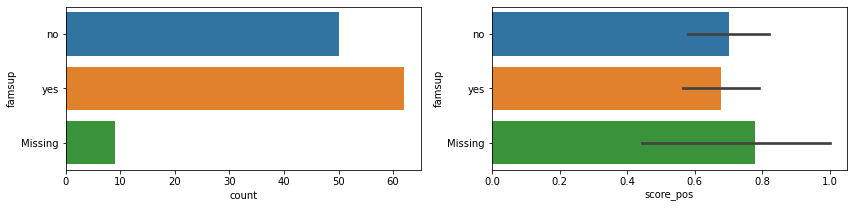

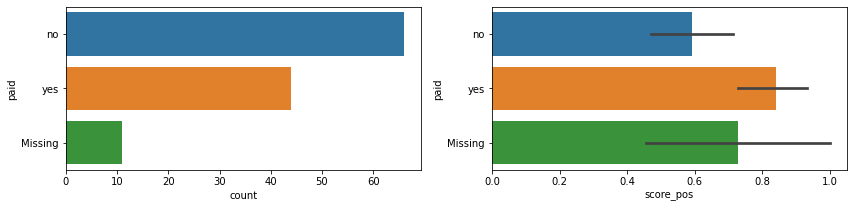

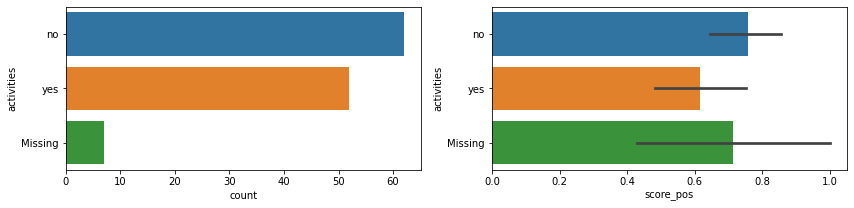

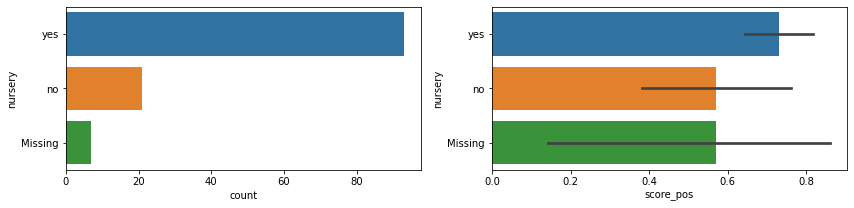

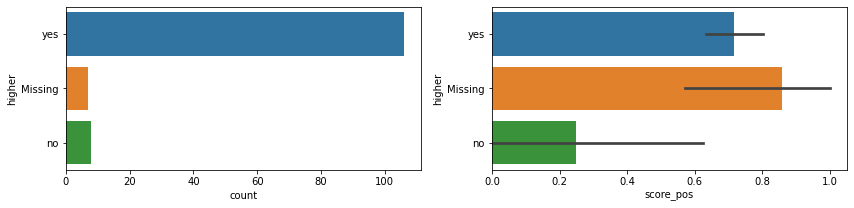

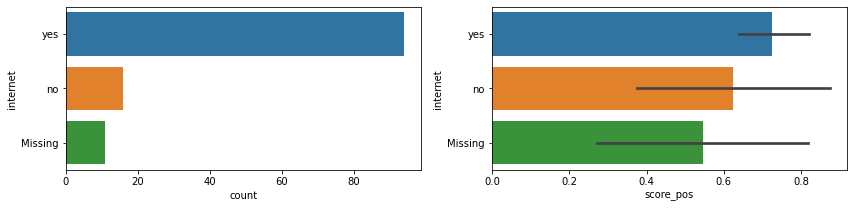

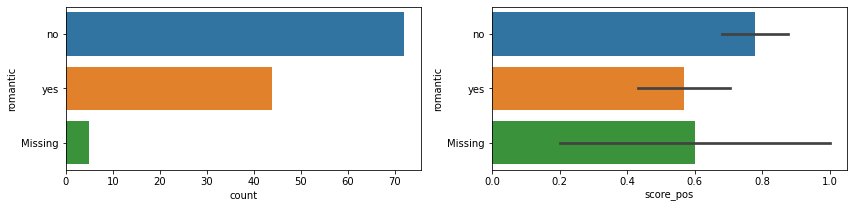

In [346]:
for col in nominal_cols:
    analyze_nominal(stud_math_0, col, 'score_pos')

Пропуски age в количестве 0 шт.
Пропуски Medu в количестве 0 шт.
Пропуски Fedu в количестве 0 шт.
Пропуски traveltime в количестве 0 шт.
Пропуски studytime в количестве 0 шт.
Пропуски failures в количестве 0 шт.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Пропуски studytime, granular в количестве 0 шт.
Пропуски famrel в количестве 0 шт.
Пропуски freetime в количестве 0 шт.
Пропуски goout в количестве 0 шт.
Пропуски health в количестве 0 шт.
Пропуски absences в количестве 0 шт.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


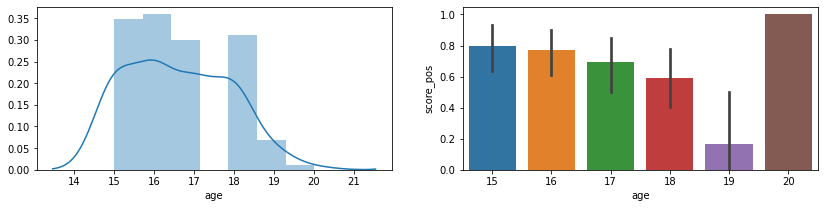

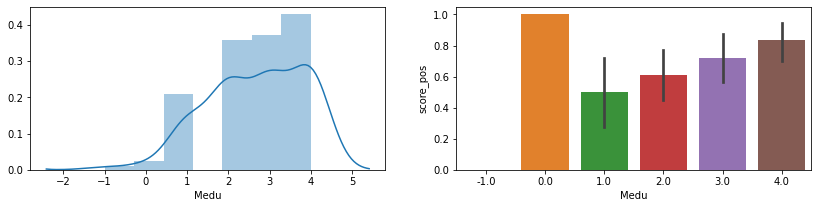

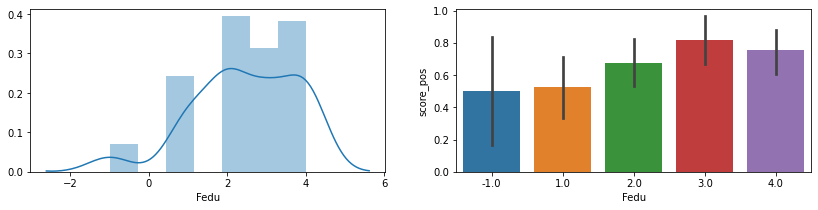

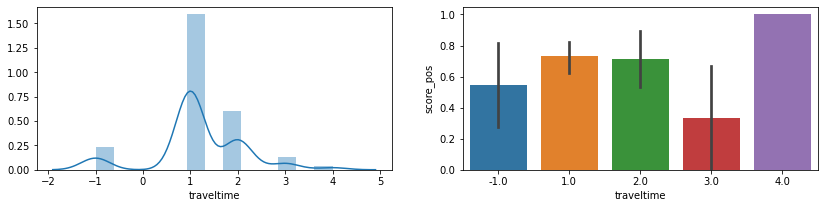

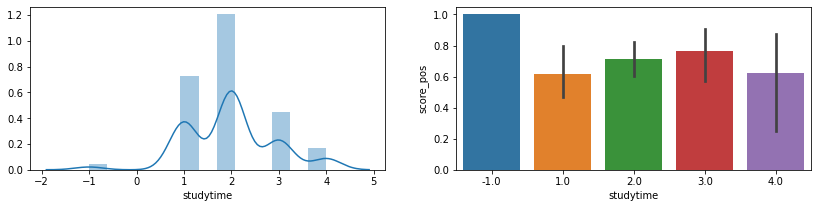

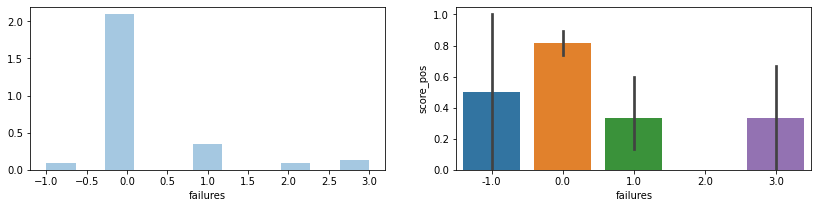

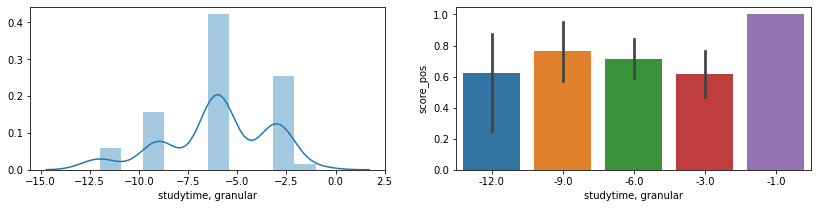

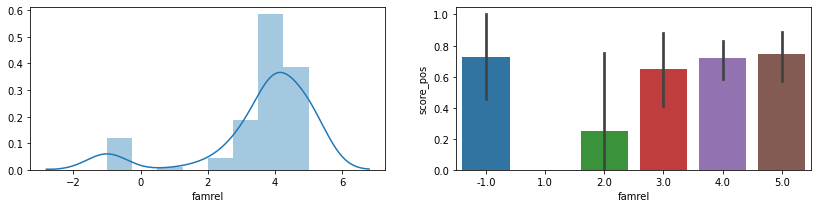

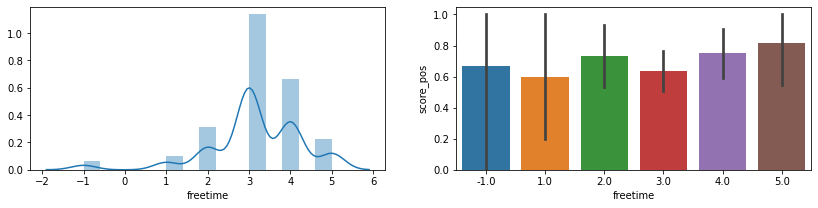

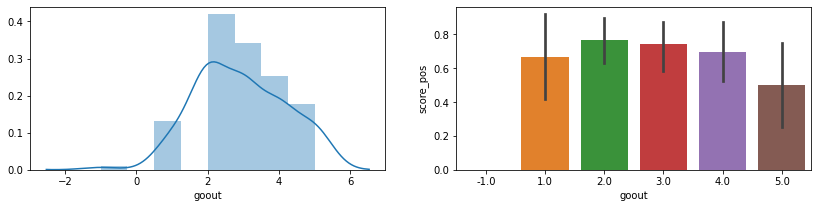

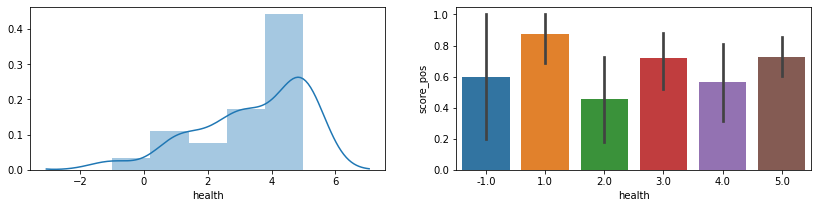

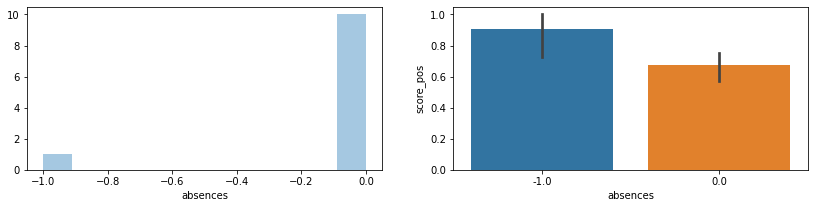

In [347]:
for col in interval_cols:
    analyze_interval(stud_math_0, col, 'score_pos')

Формируем перменные Weight of Evidence и вычисляем Information Value

In [348]:
def woe(data, var, response):
    '''Вычисление Weight of Evidence, Information Value'''
    eps = 0.000000001
    stat = data.pivot_table(values = 'score', columns = response, index = var, aggfunc=len)
    stat['share_0'] = stat[[0]] / stat[[0]].sum()
    stat['share_1'] = stat[[1]] / stat[[1]].sum()
    stat[var + '_woe'] = np.log((stat['share_1'] + eps) / (stat['share_0'] + eps))
    stat['iv'] = (stat['share_1'] - stat['share_0']) * stat[var + '_woe']
    IV = stat['iv'].sum()
    return [data.merge(stat[[var + '_woe']], on = var), IV]

vars = pd.DataFrame(columns = ['col','IV'])

for col in nominal_cols + interval_cols:
    res = woe(stud_math_0, col, 'score_pos')
    row = [col + '_woe', res[1]]
    vars.loc[len(vars)] = row
    stud_math_0 = res[0]

vars = vars.sort_values(by = ['IV'], ascending=False)
print(vars)

                        col        IV
22             failures_woe  0.759153
17                  age_woe  0.456714
11                 paid_woe  0.334670
18                 Medu_woe  0.320699
14               higher_woe  0.318884
27               health_woe  0.298183
19                 Fedu_woe  0.249973
16             romantic_woe  0.226754
8              guardian_woe  0.194898
20           traveltime_woe  0.188011
24               famrel_woe  0.162787
26                goout_woe  0.150147
9             schoolsup_woe  0.148177
28             absences_woe  0.145580
7                reason_woe  0.144342
5                  Mjob_woe  0.135356
12           activities_woe  0.106023
25             freetime_woe  0.100322
13              nursery_woe  0.095427
2               address_woe  0.088089
15             internet_woe  0.069060
21            studytime_woe  0.064369
23  studytime, granular_woe  0.064369
3               famsize_woe  0.056753
1                   sex_woe  0.027731
4           

Отбираем переменные с IV > 20% и исследуем корреляции.

Образование родителей имеет корреляцию 50%. Вероятно нужно будет оставить только образование матери.
failures является очень сильной переменной, коррелирует с age, paid, Medu на уровне 34-38% и вероятно вытеснит часть этих переменных на этапе логистической регрессии.

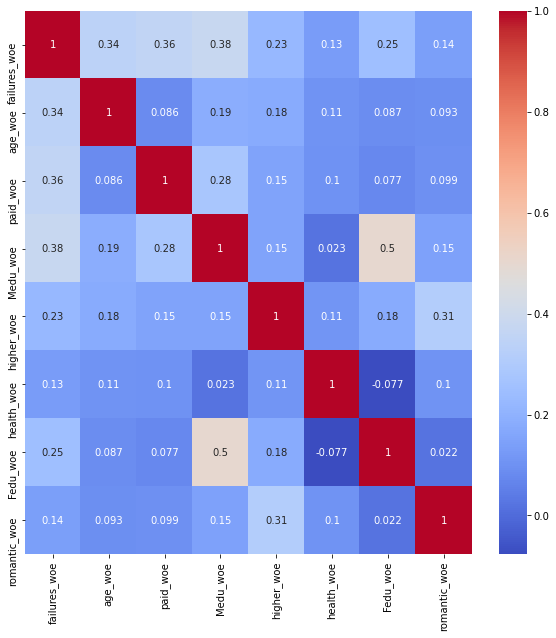

In [353]:
top_vars = list(vars[vars['IV'] > 0.2]['col'])
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(stud_math_0[top_vars].corr(), annot = True, cmap = 'coolwarm')